In [1]:
import sys
sys.path.append('..')

import argparse
import logging
import math
import os
import random
import webdataset as wds
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
from PIL import Image

from pyproj import Geod
from shapely.geometry import shape as shapey
from shapely.wkt import loads as shape_loads

import torch
from torchvision import transforms

from diffusers import StableDiffusionImg2ImgPipeline, DDIMScheduler, StableDiffusionPipeline, DDIMInverseScheduler


from diffusionsat import (
    SatUNet, DiffusionSatPipeline,
    SampleEqually,
    fmow_tokenize_caption, fmow_numerical_metadata,
    spacenet_tokenize_caption, spacenet_numerical_metadata,
    satlas_tokenize_caption, satlas_numerical_metadata,
    combine_text_and_metadata, metadata_normalize,
)

from tqdm import tqdm
from torchvision import transforms as tvt
import matplotlib.pyplot as plt


/home_nfs/jayinnn/miniconda3/envs/diffusionsat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/project/jayinnn/DiffusionSat/src/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


In [2]:
# cache location
os.environ["HF_HOME"] = "/home/jayinnn/.cache/"

In [97]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda:2")


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [98]:
pipe.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('skip_prk_steps', True),
            ('set_alpha_to_one', False),
            ('prediction_type', 'epsilon'),
            ('steps_offset', 1),
            ('_class_name', 'PNDMScheduler'),
            ('_diffusers_version', '0.6.0'),
            ('clip_sample', False)])

# Change caption/metadata here

In [3]:
caption = "a fmow satellite image of a amusement park in Australia"
# Normalized metadata: [longitude, latitude, gsd, cloud cover, year, month, day]
metadata = [ 925.8798,  345.2111, 411.4541,    0.0000,  308.3333,  166.6667, 354.8387]

# Or provide metadata values and then normalize
caption = "a fmow satellite image of a electric substation in India"
metadata = metadata_normalize([76.5712666476, 28.6965307997, 0.929417550564, 0.0765712666476, 2015, 2, 27]).tolist()
null_metadata = metadata_normalize([0.0, 0.0, 0.0, 0.05, 2015, 2, 27]).tolist()

# Pipe 1: No finetuning

In [142]:
unet1 = SatUNet.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="unet", use_metadata=False, torch_dtype=torch.float32)
pipe1 = DiffusionSatPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", unet=unet1, torch_dtype=torch.float32)
pipe1 = pipe1.to("cuda:5")

/home_nfs/jayinnn/miniconda3/envs/diffusionsat/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [143]:
unet1_inv = SatUNet.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="unet", use_metadata=False, torch_dtype=torch.float32)
pipe1_inv = DiffusionSatPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", unet=unet1, torch_dtype=torch.float32)
scheduler_config = {
    'num_train_timesteps': 1000,
    'beta_start': 0.00085,
    'beta_end': 0.012,
    'beta_schedule': 'scaled_linear',
    'trained_betas': None,
    'clip_sample': False,
    'set_alpha_to_one': False,
    'steps_offset': 1,
    'prediction_type': 'v_prediction',
    'thresholding': False,
    'dynamic_thresholding_ratio': 0.995,
    'clip_sample_range': 1.0,
    'sample_max_value': 1.0
}
scheduler_inv = DDIMInverseScheduler(**scheduler_config)
pipe1_inv.scheduler = scheduler_inv
pipe1_inv = pipe1_inv.to("cuda:5")

In [138]:
pipe_ori_img2img = StableDiffusionImg2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", unet=unet1, torch_dtype=torch.float16)
pipe_ori_img2img = pipe_ori_img2img.to("cuda:2")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.79it/s]


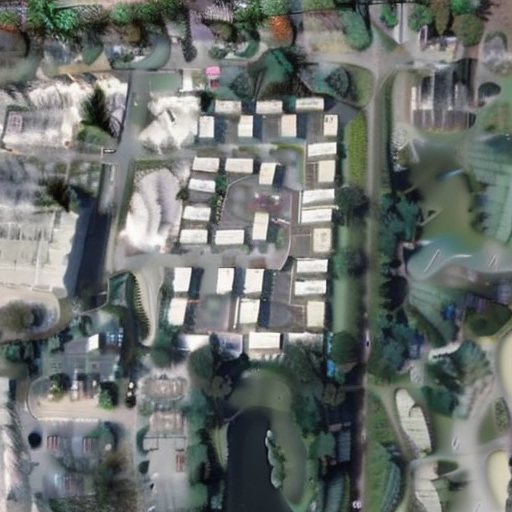

In [142]:
image = pipe_ori_img2img("a satellite image", image=img, strength=0.2, guidance_scale=7.5).images[0]
image

#### Prompt pipe 1

In [ ]:
image = pipe1(caption, num_inference_steps=50, guidance_scale=7.5, height=512, width=512).images[0]
image

# Pipe: Finetuning with metadata, SNR 5

In [4]:
# If running on CPU (not recommended), then comment-out casting to float16 and the line which shifts the pipe to cuda:2

path = '/data1/jayinnn/DiffusionSat/finetune_sd21_sn-satlas-fmow_snr5_md7norm_bs64/'
unet = SatUNet.from_pretrained(path + 'checkpoint-150000', subfolder="unet", torch_dtype=torch.float32)
pipe = DiffusionSatPipeline.from_pretrained(
    path, unet=unet,
    torch_dtype=torch.float32)
# pipe_inv = pipe.to("cuda:2")
pipe = pipe.to("cuda:2")

In [5]:
unet_inv = SatUNet.from_pretrained(path + 'checkpoint-150000', subfolder="unet", torch_dtype=torch.float32)
scheduler_config = {
    'num_train_timesteps': 1000,
    'beta_start': 0.00085,
    'beta_end': 0.012,
    'beta_schedule': 'scaled_linear',
    'trained_betas': None,
    'clip_sample': False,
    'set_alpha_to_one': False,
    'steps_offset': 1,
    'prediction_type': 'v_prediction',
    'thresholding': False,
    'dynamic_thresholding_ratio': 0.995,
    'clip_sample_range': 1.0,
    'sample_max_value': 1.0
}
scheduler_inv = DDIMInverseScheduler(**scheduler_config)
print(scheduler_inv.config)
pipe_inv = DiffusionSatPipeline.from_pretrained(
    path, unet=unet_inv,
    torch_dtype=torch.float32)
pipe_inv.scheduler = scheduler_inv
pipe_inv = pipe_inv.to("cuda:2")

/project/jayinnn/DiffusionSat/src/diffusers/schedulers/scheduling_ddim_inverse.py:137: FutureWarning: The `set_alpha_to_one` argument is deprecated. Please use `set_alpha_to_zero` instead.
  deprecate("set_alpha_to_one", "1.0.0", deprecation_message, standard_warn=False)


FrozenDict([('num_train_timesteps', 1000), ('beta_start', 0.00085), ('beta_end', 0.012), ('beta_schedule', 'scaled_linear'), ('trained_betas', None), ('clip_sample', False), ('set_alpha_to_zero', True), ('steps_offset', 1), ('prediction_type', 'v_prediction'), ('clip_sample_range', 1.0)])


In [6]:
pipe.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('clip_sample', False),
            ('set_alpha_to_one', False),
            ('steps_offset', 1),
            ('prediction_type', 'v_prediction'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('clip_sample_range', 1.0),
            ('sample_max_value', 1.0),
            ('_class_name', 'DDIMScheduler'),
            ('_diffusers_version', '0.17.0.dev0'),
            ('skip_prk_steps', True)])

In [7]:
pipe_inv.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('clip_sample', False),
            ('set_alpha_to_zero', True),
            ('steps_offset', 1),
            ('prediction_type', 'v_prediction'),
            ('clip_sample_range', 1.0)])

In [8]:
def img_to_latents(x, vae):
    x = 2. * x - 1.
    posterior = vae.encode(x).latent_dist
    latents = posterior.mean * 0.18215
    return latents

@torch.no_grad()
def ddim_inversion(pipe, pipe_inv, img, num_steps:int=50, noise_level=1.0, guidance_scale=1):
    device = pipe.device
    vae = pipe_inv.vae
    img = tvt.ToTensor()(img)[None, ...]
    img = img.to(device)

    latents = img_to_latents(img, vae)

    pipe_inv.scheduler.set_timesteps(num_steps)
    pipe.scheduler.set_timesteps(num_steps)

    if noise_level != 1.0:
        pipe_inv.scheduler.timesteps = pipe_inv.scheduler.timesteps[:int(num_steps * noise_level)]
        pipe.scheduler.timesteps = pipe.scheduler.timesteps[-int(num_steps * noise_level):]
        

    inv_latents, _ = pipe_inv("a fmow satellite image", negative_prompt="", metadata=null_metadata,
                          guidance_scale=guidance_scale,
                          width=img.shape[-1], height=img.shape[-2],
                          output_type='latent', return_dict=False,
                          num_inference_steps=len(pipe_inv.scheduler.timesteps), latents=latents)
    
    image = pipe("a fmow satellite image", negative_prompt="", metadata=null_metadata, num_inference_steps=len(pipe.scheduler.timesteps), guidance_scale=guidance_scale, height=512, width=512,
                 latents=inv_latents)
    fig, ax = plt.subplots(1, 2, figsize=(10, 20))
    ax[0].imshow(tvt.ToPILImage()(img[0]))
    ax[1].imshow(image.images[0])
    plt.show()

    return inv_latents
    

In [9]:
@torch.no_grad()
def sample(pipe, start_latents, prompt, metadata, negative_prompt="", num_steps: int=50, strength: float= 1.0, guidance_scale=1):
    device = pipe.device
    start_step = int(num_steps * (1.0 - strength))
    latents = start_latents.clone()
    pipe.scheduler.set_timesteps(num_steps)
    # text_embeddings = pipe._encode_prompt(
    #     prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    # )
    text_embeddings = pipe._encode_prompt(
        prompt, device, 1, True, negative_prompt
    )
    input_metadata = pipe.prepare_metadata(1, metadata, True, device, text_embeddings.dtype)
    for i in tqdm(range(start_step, num_steps)):
        t = pipe.scheduler.timesteps[i]

        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        noise_pred = pipe.unet(
            latent_model_input, t, metadata=input_metadata, encoder_hidden_states=text_embeddings,
            cross_attention_kwargs=None).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images, latents

In [10]:
@torch.no_grad()
def partial_ddim_inversion(pipe, pipe_inv, img, num_steps:int=50, strength=1.0, guidance_scale=1, plot=False):
    device = pipe.device
    vae = pipe_inv.vae
    img = tvt.ToTensor()(img)[None, ...]
    img = img.to(device)

    latents = img_to_latents(img, vae)

    _, inv_latents = sample(pipe_inv, latents, 
                            prompt="a fmow satellite image",
                            metadata=null_metadata,
                            num_steps=num_steps,
                            strength=strength,
                            guidance_scale=guidance_scale)
    image, _ = sample(pipe, inv_latents,
                      prompt="a fmow satellite image",
                      metadata=null_metadata,
                      num_steps=num_steps,
                      strength=strength,
                      guidance_scale=guidance_scale)
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(10, 20))
        ax[0].imshow(tvt.ToPILImage()(img[0]))
        ax[1].imshow(image[0])
        plt.show()

    return image[0]

#### Prompt Pipe

Play around with guidance scale and number of inference steps to generate images

In [13]:
caption = "a fmow satellite image of a electric substation in Taiwan"
metadata = metadata_normalize([76.5712666476, 28.6965307997, 0.929417550564, 0.0765712666476, 2015, 2, 27]).tolist()
metadata = metadata_normalize([0.0, 0.0, 0.0, 0.05, 2015, 2, 27]).tolist()

In [66]:
sample(caption, metadata, negative_prompt=negative_prompt, num_inference_steps=50)[0].resize((256, 256))

NameError: name 'sample' is not defined

/project/jayinnn/DiffusionSat/notebooks/../diffusionsat/pipeline.py:594: FutureWarning: Accessing config attribute `in_channels` directly via 'SatUNet' object attribute is deprecated. Please access 'in_channels' over 'SatUNet's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.02it/s]


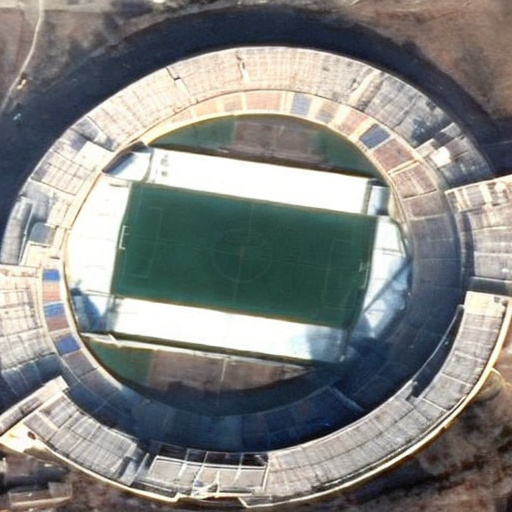

In [16]:
image = pipe("a fmow satellite image", metadata=null_metadata, num_inference_steps=50, guidance_scale=7.5, height=512, width=512).images[0]
image

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]


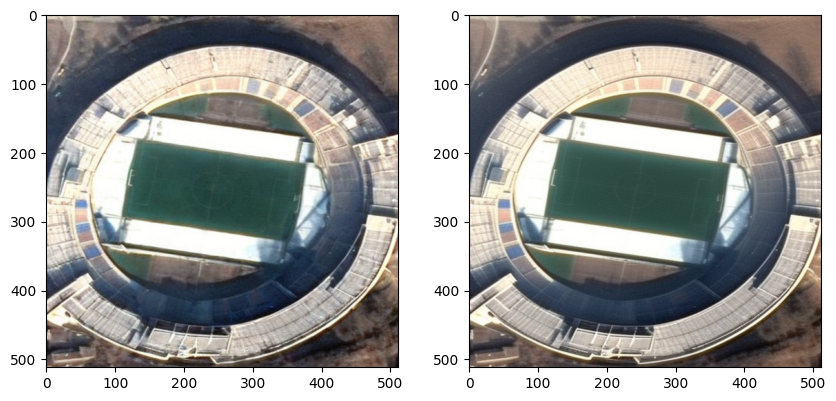

In [29]:
latents = partial_ddim_inversion(pipe, pipe_inv, image, num_steps=50, strength=0.1, guidance_scale=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 16.84it/s]


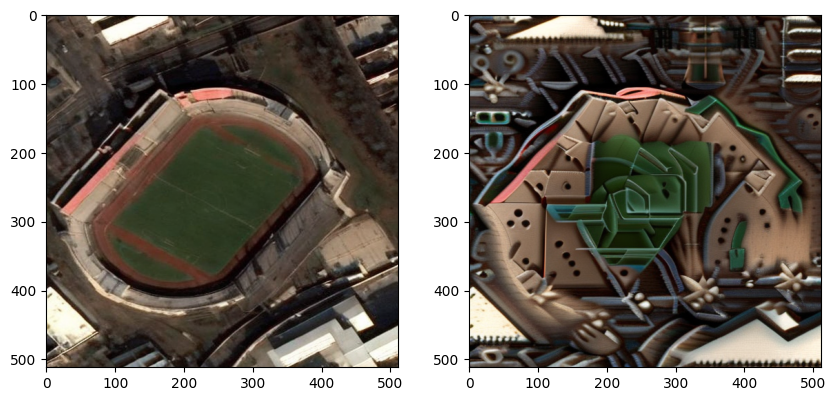

In [161]:
latents = ddim_inversion(pipe1, pipe1_inv, image, num_steps=50, guidance_scale=1)

In [9]:
pipe_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(path, unet=unet, torch_dtype=torch.float32)
pipe_img2img = pipe_img2img.to("cuda:2")

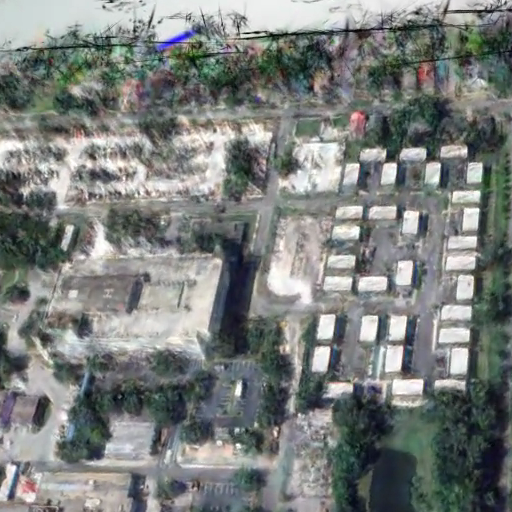

In [38]:
from PIL import Image, ImageDraw
img = Image.open('0332.png')
w, h = img.size
max_x = w - 512  # Maximum x coordinate to start crop
max_y = h - 512  # Maximum y coordinate to start crop

# Generate random starting coordinates
x = random.randint(0, max_x)
y = random.randint(0, max_y)

# Crop the image (left, top, right, bottom)
img = img.crop((x, y, x + 512, y + 512))
# img = img.resize((512, 512))
draw = ImageDraw.Draw(img, 'RGBA')
width, height = img.size

# Generate random starting coordinates for the rectangle
x1 = random.randint(0, width - 100)
y1 = random.randint(0, height - 100)

# Calculate ending coordinates (20x20 pixels from start point)
x2 = x1 + 100
y2 = y1 + 100

# Draw filled black rectangle with 20% opacity
# Alpha value is 51 (20% of 255)

# draw.rectangle([x1, y1, x2, y2], fill=(200, 123, 20, 128))
img

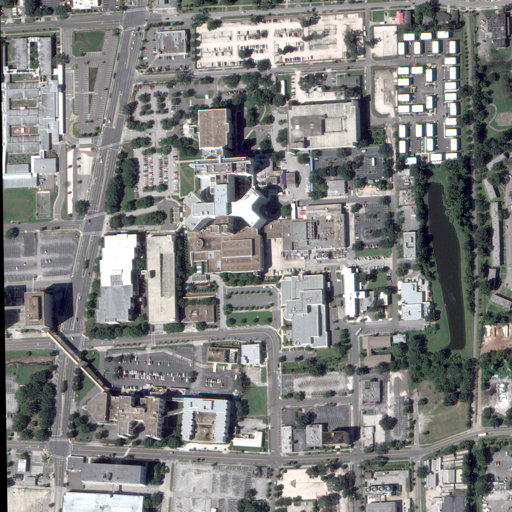

In [5]:
img = Image.open("JAX_068_001_RGB.png")
img = img.resize((512, 512))
img

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.64it/s]


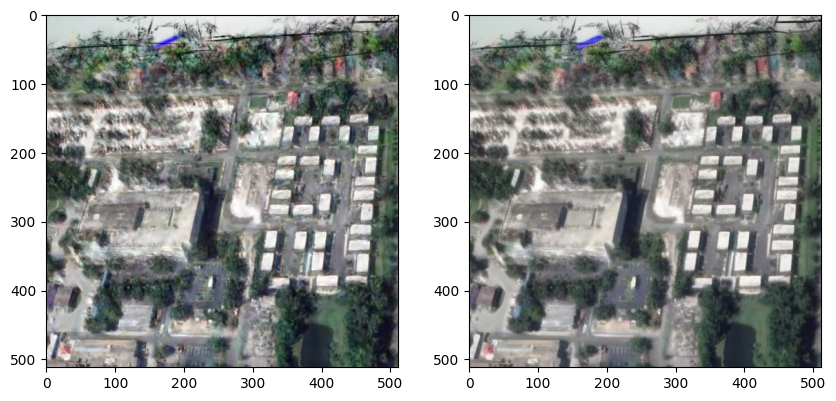

In [41]:
latents = latents = partial_ddim_inversion(pipe, pipe_inv, img, num_steps=100, strength=0.05, guidance_scale=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.81it/s]


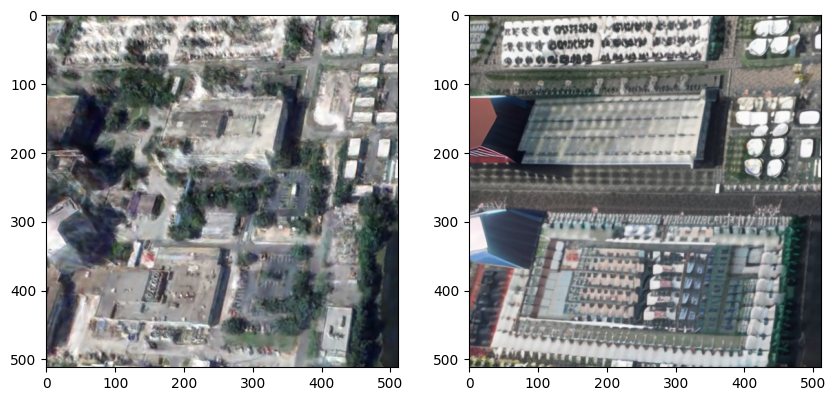

In [162]:
latents = ddim_inversion(pipe1, pipe1_inv, img, num_steps=100, guidance_scale=1)

In [7]:
caption = "a fmow satellite image"

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.60it/s]


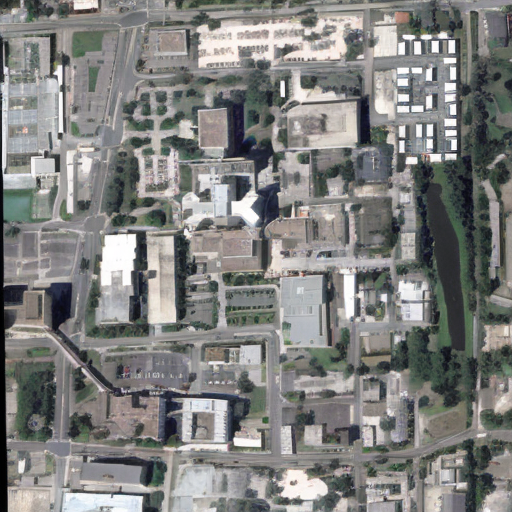

In [13]:
image = pipe_img2img(caption, image=img, strength=0.1, num_inference_steps=100, guidance_scale=1).images[0]
image

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.63it/s]


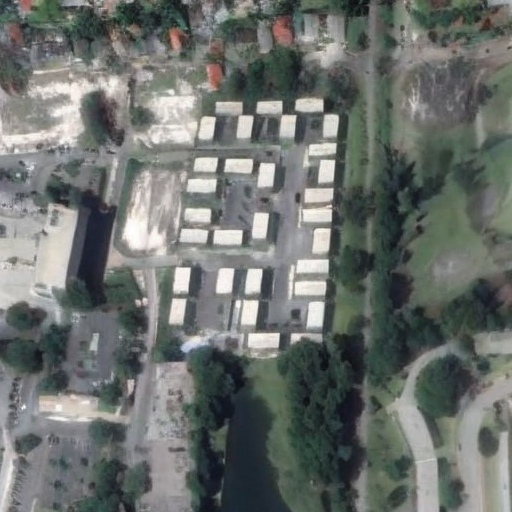

In [144]:
image = pipe_img2img(caption, image=img, strength=0.2, guidance_scale=7.5).images[0]
image

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 26.02it/s]


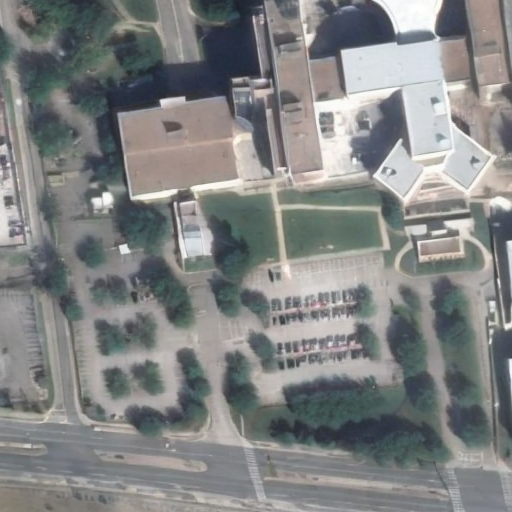

In [120]:
image = pipe_img2img(caption, image=img, strength=0.3, guidance_scale=7.5).images[0]
image

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.11it/s]


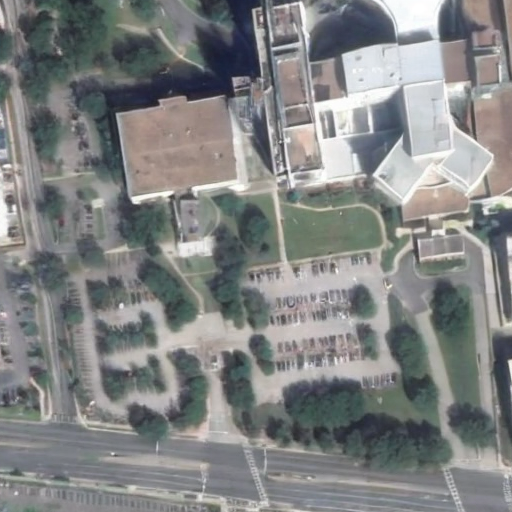

In [122]:
image = pipe_img2img(caption, image=img, strength=0.2, guidance_scale=7.5).images[0]
image

# Orbit video test

In [11]:
import cv2

In [15]:
def video_to_pil_images(video_path):
    # Initialize the video capture
    cap = cv2.VideoCapture(video_path)
    
    frames = []
    
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
        
        # If frame is read correctly ret is True
        if not ret:
            break
            
        # Convert BGR to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert to PIL Image
        pil_image = Image.fromarray(rgb_frame)
        
        frames.append(pil_image)
    
    # Release the video capture object
    cap.release()
    
    return frames

def read_images_from_folder(folder_path):
    path_imgs = sorted(os.listdir(folder_path))
    frames = []
    for path_img in path_imgs:
        if not ".png" in path_img:
            continue
        frames.append(Image.open(os.path.join(folder_path, path_img)))

    return frames
    

def pil_images_to_video(frames, output_path, fps=24, resize=None, quality=None):
    """
    Convert frames to video with more options
    
    Args:
        frames: List of PIL Images or numpy arrays
        output_path (str): Output video path
        fps (int): Frames per second
        resize (tuple): Optional (width, height) to resize frames
        quality (int): Optional video quality (0-100, higher is better)
    """
    if not frames:
        raise ValueError("No frames provided")
        
    # Convert first frame to numpy and get size
    if isinstance(frames[0], Image.Image):
        first_frame = np.array(frames[0])
    else:
        first_frame = frames[0]
    
    height, width = first_frame.shape[:2]
    
    # Apply resize if specified
    if resize:
        width, height = resize
    
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Set quality if specified
    if quality is not None:
        quality = max(0, min(100, quality))  # Ensure between 0 and 100
        out.set(cv2.VIDEOWRITER_PROP_QUALITY, quality)
    
    for frame in frames:
        # Convert PIL Image to numpy array
        if isinstance(frame, Image.Image):
            frame = np.array(frame)
        
        # Resize if needed
        if resize:
            frame = cv2.resize(frame, resize)
            
        # Convert RGB to BGR for OpenCV
        if frame.shape[-1] == 3:  # If has color channels
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            
        out.write(frame)
    
    out.release()    

In [19]:
# read image from mp4
video_path = "/project/jayinnn/mip-splatting/satellite_wild_op_loss/JAX_068_op_01_depth_05_d20000/video/ours_30000/r200_e60_fov60.mp4"
frames = video_to_pil_images(video_path)

In [18]:
# read image from folder
folder_path = "/project/jayinnn/mip-splatting/satellite_wild_op_loss/JAX_068_op_01_depth_05_d20000/video/ours_20000/r200_e85_fov60_frames"
frames = read_images_from_folder(folder_path)
print(f"Read {len(frames)} frames")

Read 240 frames


In [25]:
refine_frames = []
for frame in frames:
    img = partial_ddim_inversion(pipe, pipe_inv, frame, num_steps=50, strength=0.1, guidance_scale=1, plot=False)
    refine_frames.append(img)

100%|████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.64it/s]


In [26]:
# save refine frames
output_path = "/project/jayinnn/SatelliteSfM/data/DFC2019_iterative/JAX_068/images"
os.makedirs(output_path, exist_ok=True)
for idx, frame in enumerate(refine_frames):
    frame.save(os.path.join(output_path, '{0:05d}'.format(idx) + ".png"))

In [29]:
# pil_images_to_video(refine_frames, video_path.replace(".mp4", "_s01_cfg1_refine.mp4"))
pil_images_to_video(refine_frames, folder_path.replace("_frames", "_s01_cfg1_refine.mp4"))

In [22]:
# SDEdit
refine_frames = []
for frame in frames:
    img = pipe_img2img(caption, image=frame, strength=0.25, num_inference_steps=50, guidance_scale=1).images[0]
    refine_frames.append(img)
pil_images_to_video(refine_frames, video_path.replace(".mp4", "_refine_sdedit.mp4"))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.81it/s]
